## Basic usage of binference for DARWIN sensitivity

Andrii Terliuk, based on Jacques example


First , let's add a location where binference in located

In [1]:
import os, sys
sys.path.append("/work/pat/terliuk/darwin_binference/master/")

And now - loading all the necessary tools

In [2]:
from binference.likelihoods.ll_darwin import InferenceObject
from binference.utils import read_neyman_threshold
from binference.likelihoods.ll_darwin import minimize_kwargs

from blueice.inference import bestfit_scipy


import numpy as np
import scipy.stats as sps
from scipy.interpolate import interp1d
from scipy import optimize
from inference_interface import toyfiles_to_numpy
import matplotlib.pyplot as plt

import pkg_resources
from tqdm import tqdm

Welcome to JupyROOT 6.22/08


### Let's create inference object

This will allows us to generate pseudo data toys and fit them

In [3]:
wimp_mass = 50 # injected signal WIMP mass
livetime = 31.48629821 #ty, equals to 1 year  of detector running for these templates
wimp_masses = [6,10,20,50,100,200,1000]
threshold_name = None # we can compute and create critical values from toys, but we will use 

In [4]:
darwin_stat_model = InferenceObject(wimp_mass = wimp_mass,
                                    wimp_masses=wimp_masses,
                                    livetime=livetime, limit_threshold=threshold_name,
                                   )

Computing/loading models on one core: 100%|██████████| 7/7 [00:00<00:00, 143.08it/s]


### Event expectation
we can get average event expectation for a given mass

In [5]:
exp_binference = darwin_stat_model.get_mus(wimp_mass=wimp_mass)
exp_binference

{'er': 1639.7084548039368,
 'cevns': 20.50397203807086,
 'atnu': 1.372302585920718,
 'solarnu': 1543.4813944963178,
 'signal': 6.933966266797275}

### And let's generate toy experiment and look at different populations

In [6]:
inj_signal=0.
generate_args = dict(
    signal_rate_multiplier=inj_signal, # in 1e-48 cm^2
    wimp_mass = 50,
    )

Here we create "data" array, that contains cs1, log10(cs2) and origin of the event

In [7]:
datas = darwin_stat_model.simulate_and_assign_data(generate_args=generate_args)

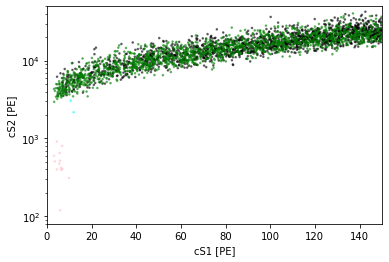

In [8]:
color_map = {0:"k",1:"pink",2:"cyan",3:"green",4:"red"}
plt.clf()
sci_data = datas[0]
colors = [color_map[s] for s in sci_data["source"]]
plt.scatter(sci_data["cs1"],10**sci_data["logcs2"],c=colors,marker=".",alpha=0.5,s=10)
plt.xlabel("cS1 [PE]")
plt.yscale("log")
plt.ylabel("cS2 [PE]")
plt.ylim([80, 50000])
plt.xlim([0, 150])
plt.show()

### Making more toys and likelihood profiles

let's generate events in background only hypothesis needed for sensitivity studies

In [9]:
inj_signal=0.
generate_args = dict(
    signal_rate_multiplier=inj_signal, # in 1e-48 cm^2
    wimp_mass = 50,
    )

Let's assign ancillary measurements/contraints to be aligned with the truth, i.e. be centered at 1.0

In [10]:
ancillary_measurements={'er_rate_multiplier': 1.0,
                        'cevns_rate_multiplier': 1.0,
                        'atnu_rate_multiplier': 1.0,
                        'solarnu_rate_multiplier': 1.0}

### And now - making scans
assigning wimp mass for this case 

In [11]:
n_toys= 100
test_wimp_mass = 50

In [12]:
### assigning scales (in 1e-48 cm2 in this case)
signal_scales = np.linspace(0.0, 2.5, 26)
scans = []
best_fits = []
####

for _ in tqdm(range(0, n_toys)):
    ## generating and assigning data
    datas = darwin_stat_model.simulate_and_assign_data(generate_args=generate_args)
    darwin_stat_model.assign_data(datas)
    ## setting constraint terms
    darwin_stat_model.assign_measurements(ancillary_measurements)
    # creating 
    llrs = np.zeros(len(signal_scales))
    ## finding best fit falue
    res_wm_best, ll_wm_best = bestfit_scipy(darwin_stat_model.ll,minimize_kwargs={"method":"Powell"}, wimp_mass=wimp_mass)
    best_fits.append(res_wm_best['signal_rate_multiplier'])
    for i,scale in enumerate(signal_scales):
        res_wm_val, ll_wm_val = bestfit_scipy(darwin_stat_model.ll,minimize_kwargs={"method":"Powell"}, 
                                                signal_rate_multiplier=scale,
                                                guess={"signal_rate_multiplier":scale},  
                                                wimp_mass=test_wimp_mass)
        llrs[i] = 2.* (ll_wm_best - ll_wm_val)
    scans.append(1.* llrs)

  0%|          | 0/100 [00:00<?, ?it/s]/toolset/py3-v1.1/RHEL_7_x86_64/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
100%|██████████| 100/100 [04:27<00:00,  2.68s/it]


#### Finding limits

Now we can make splines and find crossing points with a critical value of 2.706 (90% C.L. in asymptotic limit)

In [16]:
# Creating splines for likelihood scans
splines = []
for i in range(n_toys):
    splines.append( interp1d(signal_scales, scans[i], kind="cubic"))   
# finding crossing point with critical value
crossings = []
for i in range(n_toys):
    crossings.append(optimize.root_scalar(lambda x: splines[i](x) - 2.706,
                                          bracket=(best_fits[i], 2.5)).root)

### Plotting likelihood profiles for the toys

(0.0, 2.5)

INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode


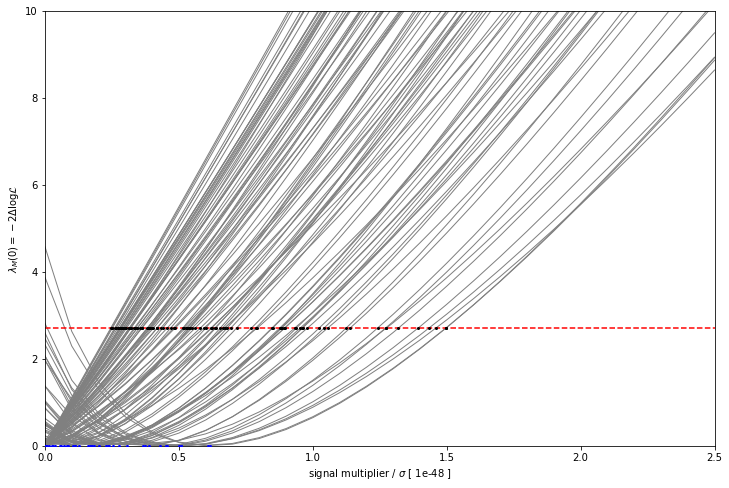

In [17]:
plt.figure(figsize=(12,8))
for i in range(n_toys):
    plt.plot(signal_scales,scans[i], c="0.5", lw=1.0)
    plt.plot(crossings[i], 2.706, marker=".", c="k", zorder=5, ms=4)
    plt.plot(best_fits[i], 0.0, marker=".", c="b", zorder=5, ms=4)

plt.axhline(2.706, ls="--", c="r")
plt.xlabel("signal multiplier / $\sigma$ [ 1e-48 ]")
plt.ylabel("$\lambda_M(0) = - 2 \Delta \log \mathcal{L}$")
plt.ylim(0,10)
plt.xlim(0,2.5)

Text(0.5, 0, 'Cross section [ 1e-48 ]')

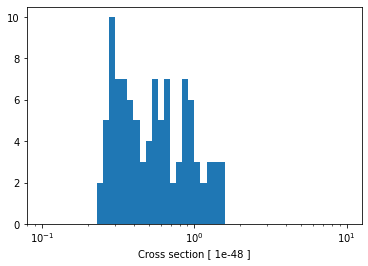

In [18]:
plt.hist(np.array(crossings), bins = 10**np.linspace(-1,1,51))
plt.xscale("log")
plt.xlabel("Cross section [ 1e-48 ]")